In [30]:
import pandas as pd
import pickle
import numpy as np

p = r'../data/yahoo/train.csv'
df = pd.read_csv(p, header=None)
df.columns = ['class', 'title', 'contents', 'answer']
df = df.fillna(' ')
df['class'] = df['class'] - 1
df['text'] = df['title'] + ' ' + df['contents'] + ' ' + df['answer']
print(df.shape)
print(df['class'].value_counts())
ratio = 0.1
df_train = df.sample(frac=ratio, random_state=1).reset_index(drop=True)
print(df_train.shape)
print(df_train['class'].value_counts())

p = r'../data/yahoo/test.csv'
df = pd.read_csv(p, header=None)
df.columns = ['class', 'title', 'contents', 'answer']
df = df.fillna(' ')
df['class'] = df['class'] - 1
df['text'] = df['title'] + ' ' + df['contents'] + ' ' + df['answer']
print(df.shape)
print(df['class'].value_counts())
df_test = df

df_test.head()

(1400000, 5)
4    140000
5    140000
2    140000
6    140000
1    140000
7    140000
3    140000
8    140000
9    140000
0    140000
Name: class, dtype: int64
(140000, 5)
6    14170
5    14085
0    14068
3    14057
8    14043
9    14019
7    13964
4    13928
2    13850
1    13816
Name: class, dtype: int64
(60000, 5)
8    6000
1    6000
3    6000
2    6000
4    6000
7    6000
6    6000
9    6000
0    6000
5    6000
Name: class, dtype: int64


,class,title,contents,answer,text
0,8,What makes friendship click?,How does the spark keep going?,good communication is what does it. Can you m...,What makes friendship click? How does the spar...
1,1,Why does Zebras have stripes?,What is the purpose or those stripes? Who do t...,this provides camouflage - predator vision is ...,Why does Zebras have stripes? What is the purp...
2,3,What did the itsy bitsy sipder climb up?,,waterspout,What did the itsy bitsy sipder climb up? wat...
3,3,What is the difference between a Bachelors and...,,One difference between a Bachelors and a Maste...,What is the difference between a Bachelors and...
4,2,Why do women get PMS?,,Premenstrual syndrome (PMS) is a group of symp...,Why do women get PMS? Premenstrual syndrome ...


In [31]:
from collections import Counter
from nltk.corpus import stopwords
import re


def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val, vocab=19998):
    word_list = []

    print("create vocab")
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        sent = sent.replace(r"<br />",' ')
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    print("sorting")
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:vocab]
    # creating a dict
    onehot_dict = {w:i+1 for i, w in enumerate(corpus_)}

    print('tokenizing')
    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = y_train
    encoded_test = y_val

    return final_list_train, encoded_train, final_list_test, encoded_test,onehot_dict

x_train,y_train,x_test,y_test,vocab = tokenize(x_train=df_train['text'],
                                               y_train=df_train['class'],
                                               x_val=df_test['text'],
                                               y_val=df_test['class'])

print(y_train.value_counts())
print(y_test.value_counts())

create vocab
sorting
tokenizing
6    14170
5    14085
0    14068
3    14057
8    14043
9    14019
7    13964
4    13928
2    13850
1    13816
Name: class, dtype: int64
8    6000
1    6000
3    6000
2    6000
4    6000
7    6000
6    6000
9    6000
0    6000
5    6000
Name: class, dtype: int64


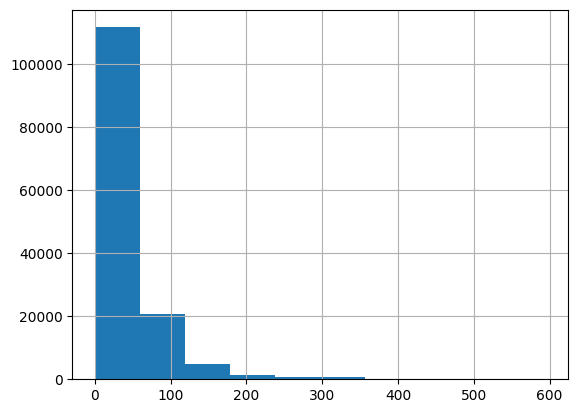

count    140000.000000
mean         41.267621
std          45.311034
min           0.000000
25%          14.000000
50%          27.000000
75%          51.000000
max         595.000000
dtype: float64

In [32]:
import matplotlib.pyplot as plt

rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [33]:
max_len = 200

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

x_train_pad = padding_(x_train,max_len)
x_test_pad = padding_(x_test,max_len)
print(len(x_train_pad), len(y_train))
print(len(x_test_pad), len(y_test))
print(len(x_train_pad[0]))

140000 140000
60000 60000
200


In [34]:
train_tokenized_idx = np.array(x_train_pad)
train_labels_np = np.array(y_train)
train_data = (train_tokenized_idx, train_labels_np)
print(train_tokenized_idx.shape)
print(train_labels_np.shape)

print('now dumping pickle')
with open(file='yahoo-train.pkl', mode='wb') as f:
    pickle.dump(train_data, f)

(140000, 200)
(140000,)
now dumping pickle


In [35]:
test_tokenized_idx = np.array(x_test_pad)
test_labels_np = np.array(y_test)
test_data = (test_tokenized_idx, test_labels_np)
print(test_tokenized_idx.shape)
print(test_labels_np.shape)

print('now dumping test pickle')
# with open(file='ag_test.pkl', mode='wb') as f:
with open(file='yahoo-test.pkl', mode='wb') as f:
    pickle.dump(test_data, f)

(60000, 200)
(60000,)
now dumping test pickle
